# Categorical predictors in ARFS


Let's illustrate how ARFS is handling the categorical predictors

In [1]:
# from IPython.core.display import display, HTML
# display(HTML("<style>.container { width:95% !important; }</style>"))
import catboost
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import gc
import shap
from boruta import BorutaPy as bp
from sklearn.datasets import fetch_openml
from sklearn.inspection import permutation_importance
from sklearn.pipeline import Pipeline
from sklearn.datasets import fetch_openml
from sklearn.inspection import permutation_importance
from sklearn.base import clone
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from lightgbm import LGBMRegressor, LGBMClassifier
from xgboost import XGBRegressor, XGBClassifier
from catboost import CatBoostRegressor, CatBoostClassifier
from sys import getsizeof, path

import arfs
import arfs.feature_selection as arfsfs
import arfs.feature_selection.allrelevant as arfsgroot
from arfs.utils import LightForestClassifier, LightForestRegressor
from arfs.benchmark import highlight_tick, compare_varimp, sklearn_pimp_bench
from arfs.utils import load_data

# plt.style.use('fivethirtyeight')
rng = np.random.RandomState(seed=42)

# import warnings
# warnings.filterwarnings('ignore')

In [2]:
print(f"Run with ARFS {arfs.__version__}")

Run with ARFS 1.0.0


In [3]:
%matplotlib inline

In [3]:
gc.enable()
gc.collect()

0

## Simple Usage

Most of the tree-based models do not handle categorical predictors without pre-processing. In the three different All Relevant Feature Selection methods, the categorical predictors are handled automatically. How?

 - the non-numeric columns are selected
 - integer encoding is performed
 - for lightGBM and XGBoost, the columns are encoded using contiguous integers and are passed as categoricals. See the [official documentation](https://lightgbm.readthedocs.io/en/latest/Advanced-Topics.html)
 - for CatBoost, the columns are encoded but the categorical columns are passed to the fit methods `estimator.fit(X_tr, y_tr, sample_weight=w_tr, cat_features=obj_feat)` (for lightGBM, this param is pass to the estimator not the fit method).
 
This is done internally and automatically, you don't have to set it yourself (if you do so, it'll throw an error).

Let's see an example using the Titanic data, with synthetic predictors added for benchmarking purpose.


In [4]:
titanic = load_data(name='Titanic')
X, y = titanic.data, titanic.target

In [5]:
X.dtypes

pclass          object
sex             object
embarked        object
random_cat      object
is_alone        object
title           object
age            float64
family_size    float64
fare           float64
random_num     float64
dtype: object

In [6]:
X.head()

,pclass,sex,embarked,random_cat,is_alone,title,age,family_size,fare,random_num
0,1.0,female,S,Fry,1,Mrs,29.0000,0.0,211.3375,0.496714
1,1.0,male,S,Bender,0,Master,0.9167,3.0,151.5500,-0.138264
2,1.0,female,S,Thanos,0,Mrs,2.0000,3.0,151.5500,0.647689
3,1.0,male,S,Morty,0,Mr,30.0000,3.0,151.5500,1.523030
4,1.0,female,S,Morty,0,Mrs,25.0000,3.0,151.5500,-0.234153


## GrootCV

Repeated k-fold: 100%|██████████| 25/25 [00:04<00:00,  6.07it/s]


The selected features: ['pclass' 'sex' 'title' 'age' 'fare']
The agnostic ranking: [2 2 1 1 1 2 2 1 2 1]
The naive ranking: ['sex', 'pclass', 'fare', 'age', 'title', 'embarked', 'family_size', 'random_num', 'random_cat', 'is_alone']


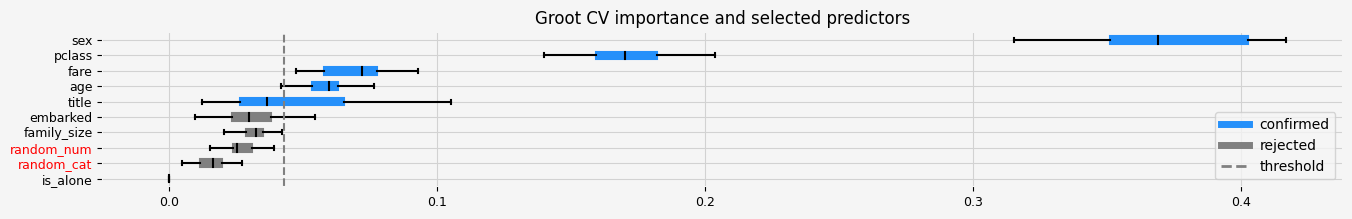

CPU times: total: 26.4 s
Wall time: 4.55 s


In [7]:
%%time
# GrootCV
feat_selector = arfsgroot.GrootCV(objective='binary', cutoff=1, n_folds=5, n_iter=5, silent=True)
feat_selector.fit(X, y, sample_weight=None)
print(f"The selected features: {feat_selector.get_feature_names_out()}")
print(f"The agnostic ranking: {feat_selector.ranking_}")
print(f"The naive ranking: {feat_selector.ranking_absolutes_}")
fig = feat_selector.plot_importance(n_feat_per_inch=5)

# highlight synthetic random variable
fig = highlight_tick(figure=fig, str_match='random')
fig = highlight_tick(figure=fig, str_match='genuine', color='green')
plt.show()

## BoostAGroota

BoostaGRoota round:  20%|██        | 2/10 [00:06<00:24,  3.03s/it]


The selected features: ['pclass' 'sex' 'fare']
The agnostic ranking: [2 2 1 1 1 1 1 1 2 1]
The naive ranking: ['sex', 'pclass', 'fare', 'age', 'embarked', 'random_num', 'family_size', 'random_cat', 'title', 'is_alone']


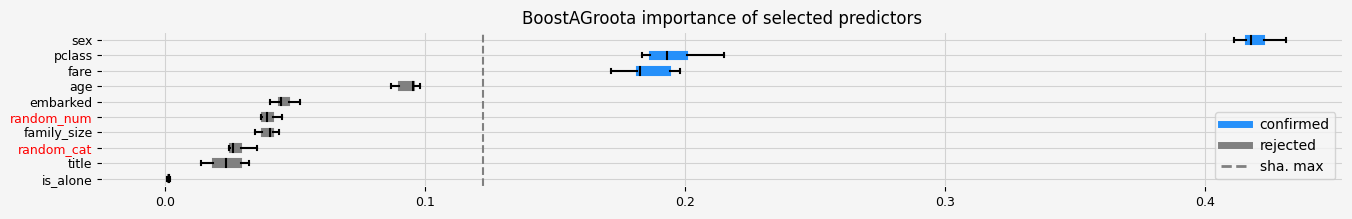

In [8]:
# be sure to use the same but non-fitted estimator
model = LGBMClassifier(random_state=1258, verbose=-1, n_estimators=100)

# BoostAGroota
feat_selector = arfsgroot.BoostAGroota(est=model, cutoff=1, iters=10, max_rounds=10, delta=0.1, importance='shap')
feat_selector.fit(X, y, sample_weight=None)
print(f"The selected features: {feat_selector.get_feature_names_out()}")
print(f"The agnostic ranking: {feat_selector.ranking_}")
print(f"The naive ranking: {feat_selector.ranking_absolutes_}")
fig = feat_selector.plot_importance(n_feat_per_inch=5)

# highlight synthetic random variable
fig = highlight_tick(figure=fig, str_match='random')
fig = highlight_tick(figure=fig, str_match='genuine', color='green')
plt.show()

## Leshy

You don't have to worry about the encoding, everything is performed internally. Even if you used CatBoost, the categorical predictors are handled internally as well.

In [9]:
cat_idx = [X.columns.get_loc(col) for col in titanic.categorical]

Leshy iteration:  90%|█████████ | 9/10 [00:11<00:01,  1.25s/it]




Leshy finished running using shap var. imp.

Iteration: 	10 / 10
Confirmed: 	3
Tentative: 	0
Rejected: 	7
All relevant predictors selected in 00:00:11.25
The selected features: ['pclass' 'sex' 'fare']
The agnostic ranking: [1 1 2 6 8 5 4 7 1 3]
The naive ranking: ['sex', 'pclass', 'fare', 'embarked', 'random_num', 'age', 'title', 'random_cat', 'family_size', 'is_alone']


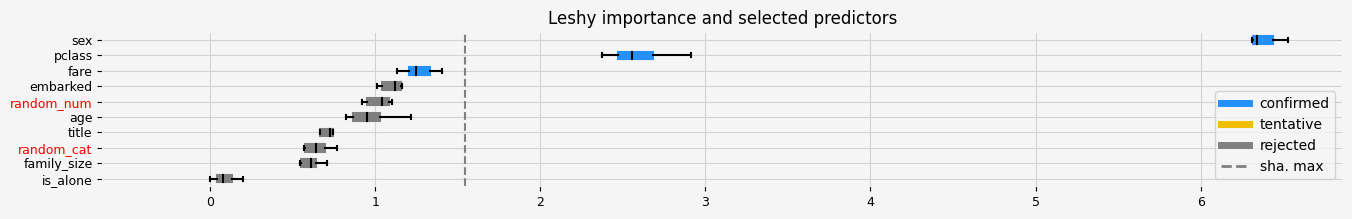

CPU times: total: 1min 15s
Wall time: 11.5 s


In [10]:
%%time
# Leshy
model = LGBMClassifier(random_state=42, verbose=-1, n_estimators=100)

# Leshy, all the predictors, no-preprocessing
feat_selector = arfsgroot.Leshy(model, 
                                n_estimators=1000, 
                                verbose=1, 
                                max_iter=10, 
                                random_state=42, 
                                importance='shap')

feat_selector.fit(X, y, sample_weight=None)
print(f"The selected features: {feat_selector.get_feature_names_out()}")
print(f"The agnostic ranking: {feat_selector.ranking_}")
print(f"The naive ranking: {feat_selector.ranking_absolutes_}")
fig = feat_selector.plot_importance(n_feat_per_inch=5)

# highlight synthetic random variable
fig = highlight_tick(figure=fig, str_match='random')
fig = highlight_tick(figure=fig, str_match='genuine', color='green')
plt.show()

For CatBoost, you just have to configure the estimator without taking care of the categorical predictors. They will be passed to the fit method internally, as illustrated in the code snippet of the ARFS package

```python
[...]
    obj_feat = list(set(list(X_tr.columns)) - set(list(X_tr.select_dtypes(include=[np.number]))))
[...]
    if check_if_tree_based(estimator):
        try:
            # handle cat features if supported by the fit method
            if is_catboost(estimator) or ('cat_feature' in estimator.fit.__code__.co_varnames):
                model = estimator.fit(X_tr, y_tr, sample_weight=w_tr, cat_features=cat_idx)
            else:
                model = estimator.fit(X_tr, y_tr, sample_weight=w_tr)
[...]
```

Leshy iteration:  90%|█████████ | 9/10 [00:33<00:03,  3.74s/it]




Leshy finished running using shap var. imp.

Iteration: 	10 / 10
Confirmed: 	5
Tentative: 	2
Rejected: 	3
All relevant predictors selected in 00:00:33.64
The selected features: ['pclass' 'sex' 'embarked' 'title' 'fare']
The agnostic ranking: [1 1 1 3 4 1 2 2 1 5]
The naive ranking: ['title', 'pclass', 'fare', 'sex', 'embarked', 'family_size', 'age', 'random_cat', 'is_alone', 'random_num']


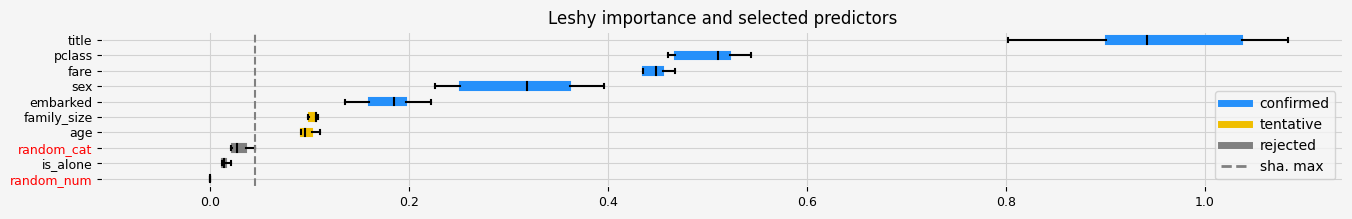

CPU times: total: 1min
Wall time: 33.9 s


In [11]:
%%time
model = CatBoostClassifier(random_state=42, verbose=0)

# Leshy, all the predictors, no-preprocessing
feat_selector = arfsgroot.Leshy(model, 
                                n_estimators=100, 
                                verbose=1, 
                                max_iter=10, 
                                random_state=42, 
                                importance='shap')

feat_selector.fit(X, y, sample_weight=None)
print(f"The selected features: {feat_selector.get_feature_names_out()}")
print(f"The agnostic ranking: {feat_selector.ranking_}")
print(f"The naive ranking: {feat_selector.ranking_absolutes_}")
fig = feat_selector.plot_importance(n_feat_per_inch=5)

# highlight synthetic random variable
fig = highlight_tick(figure=fig, str_match='random')
fig = highlight_tick(figure=fig, str_match='genuine', color='green')
plt.show()